In [1]:
from net import NeuralProcesses
%matplotlib inline
import matplotlib.pyplot as plt
import chainer
from chainer import Chain, Variable
import GPy
import numpy as np

In [2]:
# Parameters
n_h = 128
n_r = 128
n_z = 128
gpu = None

In [3]:
def gp_func(var, ls):
    kernel = GPy.kern.RBF(input_dim=1, variance=var, lengthscale=ls)
    N = 40
    x = np.linspace(-2, 2, N)
    x = x[:, None]
    mu = np.zeros(N)
    cov = kernel.K(x, x)
    y = np.random.multivariate_normal(mu, cov, size=1).T
    
    return x, y

### Training

In [9]:
# construct model and ship to GPU
model = NeuralProcesses(1,1, n_h, n_r, n_z, 'relu')

# set up the optimizer
opt = chainer.optimizers.Adam()
opt.setup(model)

In [10]:
x_pred = Variable(np.linspace(-2,2,100).astype(np.float32)[:,np.newaxis])
losses = []
for epoch in range(300):
    lossfs = []
    for step in range(300):
        # fetch the next batch of data
        var = np.random.choice([1])
        ls = np.random.choice([1])
        x, y = gp_func(var,ls)
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        randidx = np.random.permutation(40)
        n_target = np.random.randint(low=20,high=30)

        xb_target = Variable(x[randidx[:n_target]])
        xb_context = Variable(x[randidx[n_target:]])
        yb_target = Variable(y[randidx[:n_target]])
        yb_context = Variable(y[randidx[n_target:]])

        # forwad
        rec_loss, kl = model.train(xb_context,yb_context,xb_target,yb_target)

        # evaluate the binary cross entropy loss
        loss = (rec_loss + kl)
        lossf = loss.data
        lossfs.append(lossf)
        
        # backward/update
        model.cleargrads()
        loss.backward()
        opt.update()
    print("epoch %d : loss: %f" % (epoch, np.mean(lossfs)))
    losses.append(np.mean(lossfs))


epoch 0 : loss: 34.720711
epoch 1 : loss: 28.293896
epoch 2 : loss: 28.292383
epoch 3 : loss: 28.096422
epoch 4 : loss: 27.415665
epoch 5 : loss: 26.978994
epoch 6 : loss: 27.214470
epoch 7 : loss: 25.185013
epoch 8 : loss: 25.984531
epoch 9 : loss: 23.745735
epoch 10 : loss: 23.290373
epoch 11 : loss: 23.301695
epoch 12 : loss: 22.268486
epoch 13 : loss: 23.684437
epoch 14 : loss: 23.166080
epoch 15 : loss: 22.008522
epoch 16 : loss: 21.029411
epoch 17 : loss: 21.693764
epoch 18 : loss: 22.872705
epoch 19 : loss: 21.863647
epoch 20 : loss: 22.350151
epoch 21 : loss: 22.567932
epoch 22 : loss: 20.788454
epoch 23 : loss: 20.389818
epoch 24 : loss: 20.188467
epoch 25 : loss: 20.967096
epoch 26 : loss: 20.023783
epoch 27 : loss: 20.468626
epoch 28 : loss: 20.991600
epoch 29 : loss: 20.094925
epoch 30 : loss: 21.156755
epoch 31 : loss: 21.998930
epoch 32 : loss: 20.492727
epoch 33 : loss: 21.532263
epoch 34 : loss: 21.066885
epoch 35 : loss: 20.114075
epoch 36 : loss: 19.997581
epoch 37 : 

### Train Loss

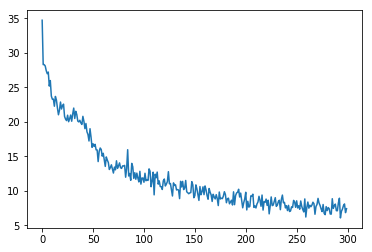

In [11]:
plt.plot(losses)

### Posterior estimate (with random number of sample)

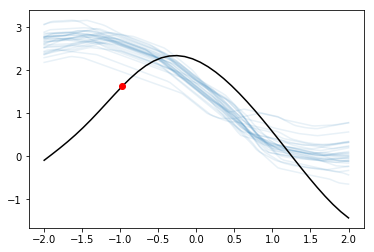

In [12]:
x, y = gp_func(var,ls)
x = x.astype(np.float32)
y = y.astype(np.float32)
randidx = np.random.permutation(40)
n_target = np.random.randint(low=1,high=40)
x_context = Variable(x[randidx[:n_target]])
y_context = Variable(y[randidx[:n_target]])
dec_mu, dec_ln_var = model.posterior(x_context, y_context, x_pred, n_draws=30)

for i, pos in enumerate(dec_mu):
    label = None
    if i == 0:
        label = "posterior"
    plt.plot(x_pred.data, pos.data.T, label=label, alpha=.1,color="C0")
plt.plot(x, y, "-",color='k')
plt.plot(x_context.data, y_context.data, "o",color='r')


### Posterior estimate (with increasing number of sample)

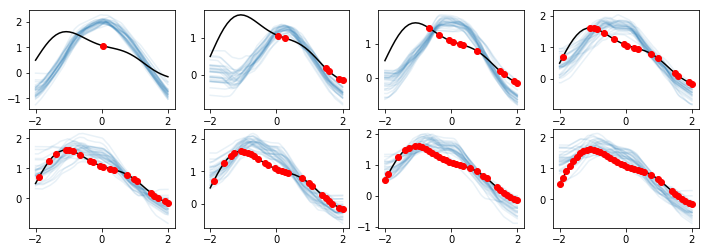

In [13]:
plt.figure(figsize=(12, 4))
x, y = gp_func(var,ls)
x = x.astype(np.float32)
y = y.astype(np.float32)
randidx = np.random.permutation(40)
for i in range(1,40,5):
    x_context = Variable(x[randidx[:i]])
    y_context = Variable(y[randidx[:i]])
    dec_mu, dec_ln_var = model.posterior(x_context, y_context, x_pred, n_draws=30)
    plt.subplot(2,4,(i/5)+1 )
    for i, pos in enumerate(dec_mu):
        label = None
        if i == 0:
            label = "posterior"
        plt.plot(x_pred.data, pos.data.T, label=label, alpha=.1,color="C0")
    plt.plot(x, y, "-",color='k')
    plt.plot(x_context.data, y_context.data, "o",color='r')
